# Progetto Data Intensive Gianmaria Di Fronzo Maggio 2025

## Abstract
Il seguente elaborato presenta un'analisi comparativa di algoritmi di **sistemi di raccomandazione** basati su tecniche di **collaborative filtering**. Utilizzando un dataset di recensioni utente-prodotto, sono stati valutati modelli secondo metriche di accuratezza predittiva. Il progetto, sviluppato in Python, include sia la fase di preprocessing dei dati sia la valutazione sperimentale, e fornisce una discussione critica sui risultati ottenuti e le prospettive future. 

## Introduzione
Questo progetto nasce con l'obiettivo di analizzare e confrontare vari algoritmi di **sistemi di raccomandazione** applicati a un dataset reale di recensioni di prodotti. I sistemi di raccomandazione sono una componente cruciale in molte piattaforme moderne, come Amazon, Netflix e Spotify, per fornire suggerimenti personalizzati agli utenti.

L'elaborato si concentra sulla valutazione di modelli **collaborativi**, utilizzando metriche standard come RMSE e MAE, per determinare quale algoritmo si comporta meglio in questo contesto. Il progetto è stato sviluppato in linguaggio **Python** utilizzando il framework `Surprise` e altri strumenti noti per l'analisi dei dati come `pandas` e `matplotlib`.

L'elaborato è frutto di lavoro **individuale** ed è stato realizzato con l'intento di comprendere meglio i meccanismi dietro i sistemi di raccomandazione e sperimentarne concretamente l'efficacia.

## Tecnologie e strumenti utilizzati
- **Linguaggio di programmazione**: Python 3.x
- **Librerie principali**:
  - `pandas`: per la manipolazione dei dati
  - `matplotlib`: per la visualizzazione grafica
  - `scikit-surprise`: per l'implementazione e valutazione dei modelli di raccomandazione
- **Ambiente di sviluppo**: Jupyter Notebook
- **Dataset**: dataset di recensioni di prodotti (CSV), caricato localmente nel notebook

# Recommendation system su dataset Sephora Products and Skincare Reviews
L’obiettivo è sviluppare un sistema di raccomandazione di prodotti cosmetici usando dati reali provenienti da Sephora. Le raccomandazioni potranno basarsi su modelli come SVD, Content-Based e XGBoost, utilizzando recensioni, caratteristiche dei prodotti e comportamento degli utenti

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nadyinky/sephora-products-and-skincare-reviews")

print("Path to dataset files:", path)

100%|██████████| 147M/147M [00:01<00:00, 84.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nadyinky/sephora-products-and-skincare-reviews/versions/2


In [ ]:
!ls /root/.cache/kagglehub/datasets/nadyinky/sephora-products-and-skincare-reviews/versions/2

product_info.csv   reviews_1250-end.csv  reviews_500-750.csv
reviews_0-250.csv  reviews_250-500.csv	 reviews_750-1250.csv


In [ ]:
import numpy as np
import pandas as pd

df_product = pd.read_csv("/root/.cache/kagglehub/datasets/nadyinky/sephora-products-and-skincare-reviews/versions/2/product_info.csv")
df_review = pd.read_csv("/root/.cache/kagglehub/datasets/nadyinky/sephora-products-and-skincare-reviews/versions/2/reviews_0-250.csv", low_memory=False)

print(df_review.columns)
print(df_product.columns)


Index(['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')
Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')


1. product_info.csv
Contiene informazioni sui prodotti.
Identificativi / Categorie
product_id, product_name, brand_id, brand_name
primary_category, secondary_category, tertiary_category
Prezzi e vendite
price_usd, value_price_usd, sale_price_usd
loves_count, reviews
Caratteristiche prodotto
size, variation_type, variation_value, variation_desc
ingredients, limited_edition, new, online_only, out_of_stock, sephora_exclusive, highlights
Struttura prodotti
child_count, child_max_price, child_min_price
2. reviews_0-250.csv
Contiene recensioni utenti per prodotti.
Identificativi
author_id, product_id, product_name, brand_name
Recensione
rating, is_recommended, helpfulness, submission_time
review_text, review_title
Feedback aggregati
total_feedback_count, total_neg_feedback_count, total_pos_feedback_count
Profilo utente
skin_tone, eye_color, skin_type, hair_color
Prezzo
price_usd

Prima scrematura: eliminazione variabili inutili o problematiche
## Manteniamo:
Variabili utili alla raccomandazione e modellazione: rating, is_recommended, review_text, skin_type, skin_tone, price_usd, brand_name, product_id, product_name, ingredients, loves_count, reviews, categories
## Rimuoviamo:
1. Identificativi puri: author_id, Unnamed: 0, brand_id
2. Ridondanti: product_name, brand_name (già presenti altrove)
3. Molto specifiche / con molte varianti / difficile da gestire subito:
variation_type, variation_value, variation_desc
child_count, child_max_price, child_min_price
4. Non informative per la raccomandazione (inizialmente):
review_title (spesso vuota), submission_time
out_of_stock, online_only, new, limited_edition, sephora_exclusive
5. Variabili con alti tassi di nulli (da valutare meglio nell'analisi esplorativa)

In [ ]:
# Rimozione colonne non informative o ridondanti
cols_to_drop_reviews = [
    'Unnamed: 0', 'author_id', 'product_name', 'brand_name', 'review_title',
    'submission_time', 'total_feedback_count', 'total_neg_feedback_count',
    'total_pos_feedback_count'
]
df_review_cleaned = df_review.drop(columns=cols_to_drop_reviews)

cols_to_drop_product = [
    'brand_id', 'product_name', 'variation_type', 'variation_value', 'variation_desc',
    'child_count', 'child_max_price', 'child_min_price',
    'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive'
]
df_product_cleaned = df_product.drop(columns=cols_to_drop_product)

# Output strutture pulite
print("Review columns (cleaned):", df_review_cleaned.columns.tolist())
print("Product columns (cleaned):", df_product_cleaned.columns.tolist())

Review columns (cleaned): ['rating', 'is_recommended', 'helpfulness', 'review_text', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'price_usd']
Product columns (cleaned): ['product_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category']


## Verifica qualità dei dati

Valori nulli nelle review:
rating                 0
is_recommended    117486
helpfulness       331832
review_text          999
skin_tone         106056
eye_color         138488
skin_type          74683
hair_color        141081
product_id             0
price_usd              0
dtype: int64

Valori nulli nei prodotti:
product_id               0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
dtype: int64


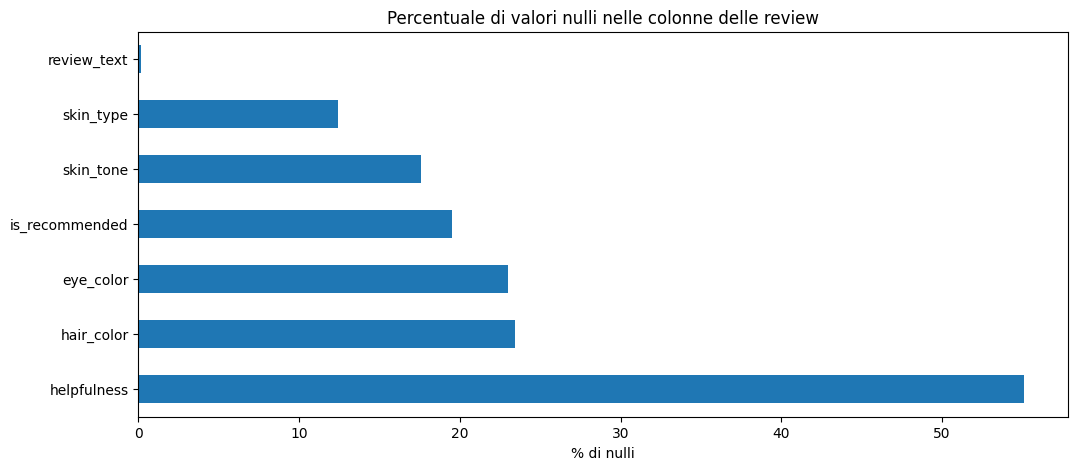

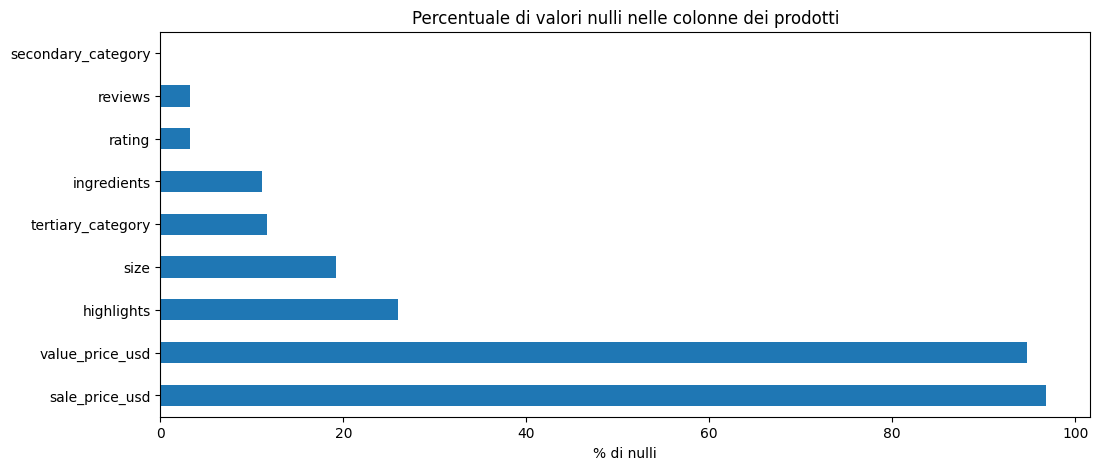

In [ ]:
# Controllo valori nulli
print("Valori nulli nelle review:")
print(df_review_cleaned.isnull().sum())

print("\nValori nulli nei prodotti:")
print(df_product_cleaned.isnull().sum())

# Percentuale di valori nulli
null_review_pct = df_review_cleaned.isnull().mean() * 100
null_product_pct = df_product_cleaned.isnull().mean() * 100

# Visualizzazione grafica dei nulli (solo se ce ne sono)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
null_review_pct[null_review_pct > 0].sort_values(ascending=False).plot(kind='barh')
plt.title("Percentuale di valori nulli nelle colonne delle review")
plt.xlabel("% di nulli")
plt.show()

plt.figure(figsize=(12, 5))
null_product_pct[null_product_pct > 0].sort_values(ascending=False).plot(kind='barh')
plt.title("Percentuale di valori nulli nelle colonne dei prodotti")
plt.xlabel("% di nulli")
plt.show()


## Statistiche descrittive e outliner

Statistiche review:
               rating  is_recommended    helpfulness      price_usd
count  602130.000000   484644.000000  270298.000000  602130.000000
mean        4.311838        0.837922       0.769722      45.723937
std         1.143692        0.368522       0.319103      35.743990
min         1.000000        0.000000       0.000000       3.000000
25%         4.000000        1.000000       0.666667      23.500000
50%         5.000000        1.000000       0.944444      38.000000
75%         5.000000        1.000000       1.000000      60.000000
max         5.000000        1.000000       1.000000     380.000000

Statistiche prodotto:
         loves_count       rating       reviews    price_usd  value_price_usd  \
count  8.494000e+03  8216.000000   8216.000000  8494.000000       451.000000   
mean   2.917957e+04     4.194513    448.545521    51.655595        91.168537   
std    6.609212e+04     0.516694   1101.982529    53.669234        79.195631   
min    0.000000e+00     1.000000

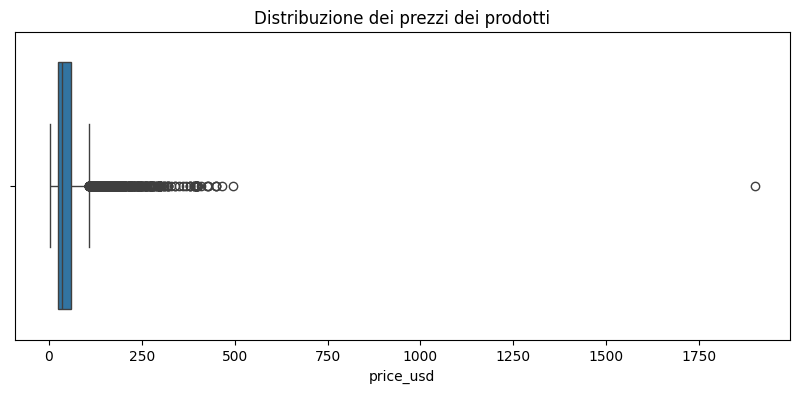

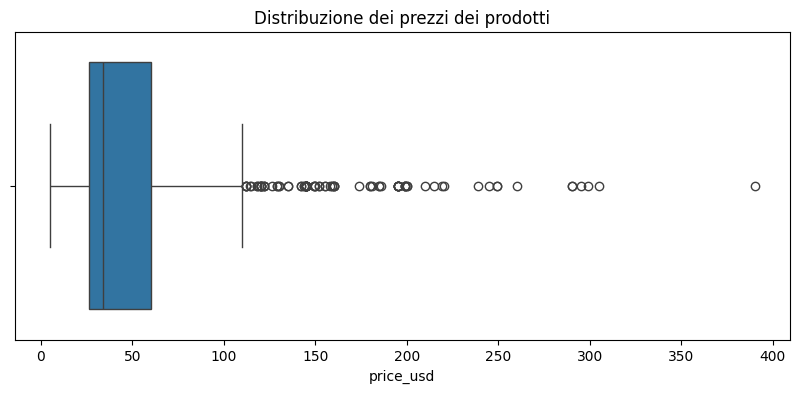

In [ ]:
# Statistiche generali
print("Statistiche review:\n", df_review_cleaned.describe())
print("\nStatistiche prodotto:\n", df_product_cleaned.describe())
print(df_product_cleaned.columns)
# Boxplot per individuare outlier
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_product_cleaned['price_usd'])
plt.title("Distribuzione dei prezzi dei prodotti")
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_product_cleaned['price_usd'][:800])
plt.title("Distribuzione dei prezzi dei prodotti")
plt.show()


1. Distribuzione fortemente asimmetrica a destra (right-skewed):
La gran parte dei prezzi è concentrata nella fascia bassa (molto vicino allo 0 fino a 100).
2. Outlier evidenti:
I tanti cerchietti neri dopo la parte destra del box rappresentano prodotti con prezzi anormalmente alti rispetto alla media del catalogo.
C'è almeno un prodotto estremo (forse un errore nei dati?) con prezzo > 1800, che merita un'ulteriore verifica.
3. Prezzo mediano e quartili:
La mediana del prezzo (linea dentro la scatola) è probabilmente intorno ai 30-40.
Il 75% dei prodotti ha un prezzo sotto 60-80.
I "baffi" terminano dove inizia la soglia degli outlier

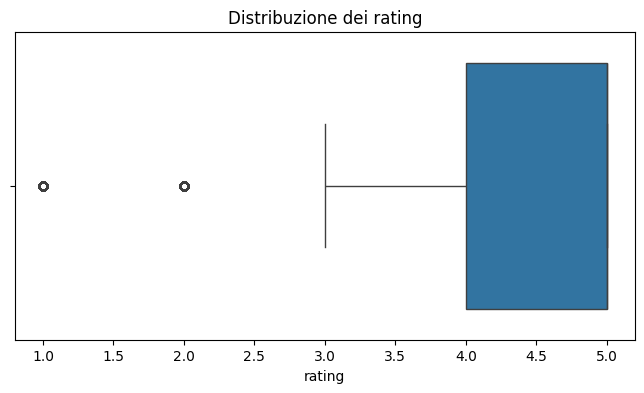

In [ ]:
if 'rating' in df_review_cleaned.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_review_cleaned['rating'])
    plt.title("Distribuzione dei rating")
    plt.show()

L’asse orizzontale mostra i valori dei rating (da 1 a 5).
La scatola (box):
Il bordo sinistro rappresenta il primo quartile (Q1, il 25% dei dati).
Il bordo destro rappresenta il terzo quartile (Q3, il 75% dei dati).
La linea interna (la mediana) è il valore centrale (Q2).
I "baffi" (le linee che escono dalla scatola) mostrano il range dei dati non considerati outlier.
I cerchi a sinistra sono outlier, ovvero valori rari e più distanti dalla massa dei dati.

1. Distribuzione sbilanciata verso l’alto:
La scatola si concentra tra 4 e 5, con la mediana vicina al 5. Questo indica che la maggior parte degli utenti lascia recensioni positive.
2. Outlier a sinistra (rating 1 e 2):
Pochi utenti hanno dato valutazioni molto basse. Sono rari, ma esistono, e rappresentano recensioni fortemente negative.
3. I rating sembrano essere limitati a una scala fissa (1-5), e non ci sono valori anomali sopra il massimo.

#Analisi delle variabili più informative

In [ ]:
# Varianza delle variabili numeriche
print("Varianza review:\n", df_review_cleaned.var(numeric_only=True).sort_values(ascending=False))
print("\nVarianza prodotto:\n", df_product_cleaned.var(numeric_only=True).sort_values(ascending=False))


Varianza review:
 price_usd         1277.632816
rating               1.308032
is_recommended       0.135809
helpfulness          0.101827
dtype: float64

Varianza prodotto:
 loves_count        4.368169e+09
reviews            1.214365e+06
value_price_usd    6.271948e+03
price_usd          2.880387e+03
sale_price_usd     5.918201e+02
rating             2.669731e-01
dtype: float64


## Correlazioni fra variabili

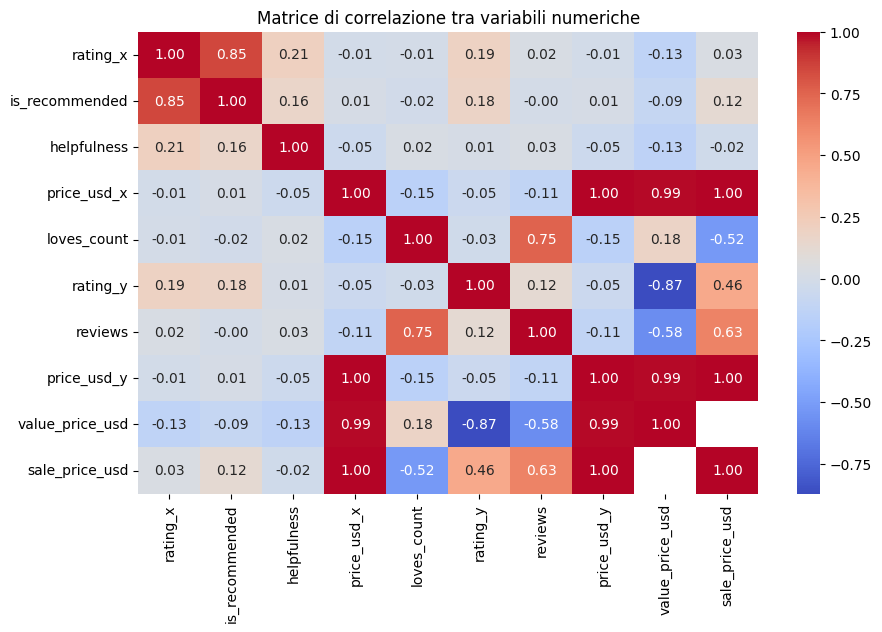

In [ ]:
# Join tra review e product se c'è una chiave comune, es. 'product_id'
df_merged = pd.merge(df_review_cleaned, df_product_cleaned, on='product_id', how='inner')

# Correlazioni numeriche
correlation_matrix = df_merged.corr(numeric_only=True)

# Visualizzazione heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice di correlazione tra variabili numeriche")
plt.show()

# Scatter tra prezzo e rating
if 'price' in df_merged.columns and 'rating' in df_merged.columns:
    sns.scatterplot(data=df_merged, x='price', y='rating', alpha=0.3)
    plt.title("Prezzo vs Rating")
    plt.xlabel("Prezzo")
    plt.ylabel("Rating")
    plt.show()


La matrice di correlazione misura quanto due variabili numeriche sono linearmente legate:

+1 = correlazione perfetta positiva (crescono insieme)


-1 = correlazione perfetta negativa (una cresce e l’altra cala)


0 = nessuna correlazione lineare

Cosa ci dice questo grafico
1. Alta correlazione tra rating e raccomandazione
rating_x vs is_recommended: 0.85
Se un prodotto ha un rating alto, è molto probabile che sia anche raccomandato.
Queste due variabili potrebbero contenere ridondanza.
2. Prezzi fortemente correlati tra loro
price_usd_x, price_usd_y, value_price_usd, sale_price_usd: > 0.99
Questi campi sono quasi duplicati o calcolati uno a partire dall’altro.
Da tenere uno solo per evitare multicollinearità nei modelli predittivi.
3. loves_count è correlato con reviews (0.75)
Ha senso: più recensioni, più “like” o “cuoricini”.
Può indicare popolarità del prodotto.
4. value_price_usd è negativamente correlato con rating_y (-0.87)
**significa che un valore prezzo più alto è associato a rating più bassi. Forse i clienti sono più critici con prodotti costosi.**
5. Correlazioni basse o irrilevanti
**helpfulness, loves_count, is_recommended hanno correlazioni molto basse con price_usd, quindi si comportano in modo indipendente.**

## Predizione
Predirremo se un prodotto è raccomandato o meno in base ai suoi dati.

## Preparando i dati:
eliminiamo sulla base dei grafici, le colonne ridondanti o troppo correlate
Colonne da eliminare:

Molti nulli: sale_price_usd, value_price_usd, helpfulness (oltre 50%)


Redundanti per correlazione > 0.99: price_usd_y, rating_y
Possibili testuali/libere: ingredients, highlights, review_text

In [ ]:
columns_to_drop = [
    'sale_price_usd', 'value_price_usd', 'price_usd_y', 'rating_y',
    'ingredients', 'highlights', 'review_text', 'helpfulness'
]
df_model = df_merged.drop(columns=columns_to_drop, errors='ignore')

print(df_model.columns)
print(df_model.head())

Index(['rating_x', 'is_recommended', 'skin_tone', 'eye_color', 'skin_type',
       'hair_color', 'product_id', 'price_usd_x', 'brand_name', 'loves_count',
       'reviews', 'size', 'primary_category', 'secondary_category',
       'tertiary_category'],
      dtype='object')
   rating_x  is_recommended skin_tone eye_color    skin_type hair_color  \
0         5             1.0       NaN     brown          dry      black   
1         1             0.0       NaN       NaN          NaN        NaN   
2         5             1.0     light     brown          dry     blonde   
3         5             1.0       NaN     brown  combination      black   
4         5             1.0     light     hazel  combination        NaN   

  product_id  price_usd_x brand_name  loves_count  reviews            size  \
0    P504322         19.0   NUDESTIX          177      1.0  2.4 oz / 70 ml   
1    P420652         24.0    LANEIGE      1081315  16118.0    0.7 oz/ 20 g   
2    P420652         24.0    LANEIGE     

## Definizione target e costruzione dataset

In [ ]:
target = 'is_recommended'
# Rimuovi righe con target NaN
df_model_clean = df_model[df_model['is_recommended'].notna()]
# Ridefinisci X e y
X = df_model_clean.drop(columns=['is_recommended'])
y = df_model_clean['is_recommended']

#One hot encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print("Colonne categoriche trovate:\n", categorical_cols)
numerical_cols = X.select_dtypes(include=['number']).columns
print("Colonne numeriche trovate:\n", numerical_cols)

X[categorical_cols] = X[categorical_cols].fillna('missing')
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Bilanciamento con SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_encoded, y)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

from collections import Counter
print("Distribuzione classi:", Counter(y))
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Distribuzione classi (train):", y_train.value_counts(normalize=True))

Colonne categoriche trovate:
 Index(['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id',
       'brand_name', 'size', 'primary_category', 'secondary_category',
       'tertiary_category'],
      dtype='object')
Colonne numeriche trovate:
 Index(['rating_x', 'price_usd_x', 'loves_count', 'reviews'], dtype='object')
Distribuzione classi: Counter({1.0: 406094, 0.0: 78550})
Train set shape: (649750, 483)
Test set shape: (162438, 483)
Distribuzione classi (train): is_recommended
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


## Assunzione per SVD
SVD richiede interazioni utente-prodotto in forma di matrice user_id × product_id con valori (es. rating o is_recommended).
Nel nostro caso, possiamo costruire una matrice di raccomandazione user_id vs product_id con valori binari (1 = raccomandato, 0 = no).

In [ ]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD

# Pulisci i NaN nei campi chiave
df_review = df_review.dropna(subset=['author_id', 'product_id', 'rating'])

# Crea la matrice utente-prodotto con valori di rating
user_item_matrix = df_review.pivot_table(index='author_id', columns='product_id', values='rating', fill_value=0)

print("Shape user_item_matrix: ", user_item_matrix.shape )
print("Rating diversi da zero: ", np.count_nonzero(user_item_matrix))

Shape user_item_matrix:  (339017, 250)
Rating diversi da zero:  598142


# Matrice fortemente sparsa, SVD è perfetto

In [ ]:
# Riduci dimensionalità (es. 50 componenti latenti)
svd = TruncatedSVD(n_components=50, random_state=42)
user_embeddings = svd.fit_transform(user_item_matrix)

import numpy as np

def recommend_products(author_id, user_item_matrix, svd_model, top_n=5):
    if author_id not in user_item_matrix.index:
        print("Utente non presente nei dati")
        return []

    # Ottieni embedding dell'utente
    user_idx = user_item_matrix.index.get_loc(author_id)
    user_vector = svd_model.transform(user_item_matrix)[user_idx]

    # Ottieni rappresentazione dei prodotti
    product_embeddings = svd_model.components_.T  # shape: (n_items, n_components)

    # Calcola punteggi stimati per tutti i prodotti
    scores = np.dot(product_embeddings, user_vector)

    # Filtra prodotti già votati
    seen_products = user_item_matrix.loc[author_id]
    unseen_product_ids = seen_products[seen_products == 0].index

    # Classifica i prodotti non visti
    ranked = sorted([(pid, scores[user_item_matrix.columns.get_loc(pid)]) for pid in unseen_product_ids],
                    key=lambda x: x[1], reverse=True)

    return ranked[:top_n]


In [ ]:
# Scegli un author_id a caso dai dati
sample_user = df_review['author_id'].dropna().unique()[5]

# Ottieni raccomandazioni
top_recommendations = recommend_products(sample_user, user_item_matrix, svd, top_n=5)

print("Top 5 prodotti consigliati per l'utente", sample_user)
for pid, score in top_recommendations:
    nome = df_product[df_product['product_id'] == pid]['product_name'].values
    print(f"Product ID: {pid}, Score: {score:.3f}, Nome: {nome[0] if len(nome) > 0 else 'N/A'}")

Top 5 prodotti consigliati per l'utente 42802569154
Product ID: P399623, Score: 0.531, Nome: Luminous Dewy Skin Mist
Product ID: P454018, Score: 0.387, Nome: The Serum Stick: Treatment & Touch Up Balm
Product ID: P409800, Score: 0.270, Nome: Cleansing & Exfoliating Wipes
Product ID: P462699, Score: 0.261, Nome: Plum Plump Hyaluronic Acid Serum
Product ID: P427536, Score: 0.183, Nome: The Deep Cleanse Gentle Exfoliating Cleanser


## Ora creiamo un sistema di raccomandazione content-based.
Questo approccio consiglia prodotti simili per contenuto (brand, ingredienti, categoria, ecc.) e non richiede interazioni esplicite come rating o acquisti.

In [ ]:
# Carica dati

# Sostituisci NaN con stringa vuota
for col in ['brand_name', 'ingredients', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'size']:
    df_product[col] = df_product[col].fillna('')

# Crea una colonna combinata per ogni prodotto
df_product['content'] = (
    df_product['brand_name'] + ' ' +
    df_product['primary_category'] + ' ' +
    df_product['secondary_category'] + ' ' +
    df_product['tertiary_category'] + ' ' +
    df_product['ingredients'] + ' ' +
    df_product['highlights'] + ' ' +
    df_product['size']
)


## Vettorizzazione del contenuto

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_product['content'])  # shape: (n_products, n_features)

print(tfidf_matrix.shape)

(8494, 5000)


## Similarità tramite coseno

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# Mappa da product_id a index e viceversa
product_id_to_index = pd.Series(df_product.index, index=df_product['product_id'])
index_to_product_id = pd.Series(df_product['product_id'].values, index=df_product.index)

def recommend_similar_products(product_id, df_product, cosine_sim, top_n=5):
    if product_id not in product_id_to_index:
        print("Prodotto non trovato.")
        return []

    idx = product_id_to_index[product_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]  # escludi se stesso

    recommended_ids = [index_to_product_id[i] for i, score in sim_scores]

    results = df_product[df_product['product_id'].isin(recommended_ids)][['product_id', 'product_name', 'brand_name']]
    return results

sample_product = df_product['product_id'].iloc[0]  # o un ID noto
recommendations = recommend_similar_products(sample_product, df_product, cosine_sim)
print("Prodotti simili a:", df_product[df_product['product_id'] == sample_product]['product_name'].values[0])
print(recommendations)


Prodotti simili a: Fragrance Discovery Set
   product_id                product_name brand_name
1     P473668     La Habana Eau de Parfum      19-69
2     P473662   Rainbow Bar Eau de Parfum      19-69
3     P473660        Kasbah Eau de Parfum      19-69
8     P472300         Capri Eau de Parfum      19-69
12    P473664  L'air Barbes Eau de Parfum      19-69


# ALBERI DI REGRESSIONE CON XGBOOST
## Obbiettivo:
Predire la probabilità che un utente raccomandi un prodotto (is_recommended) o il suo rating, utilizzando tutte le feature user+product.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predizione
y_pred = model.predict(X_test)

# Valutazione
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

RMSE: 0.0216
R2: 0.9136


## Valutazione features

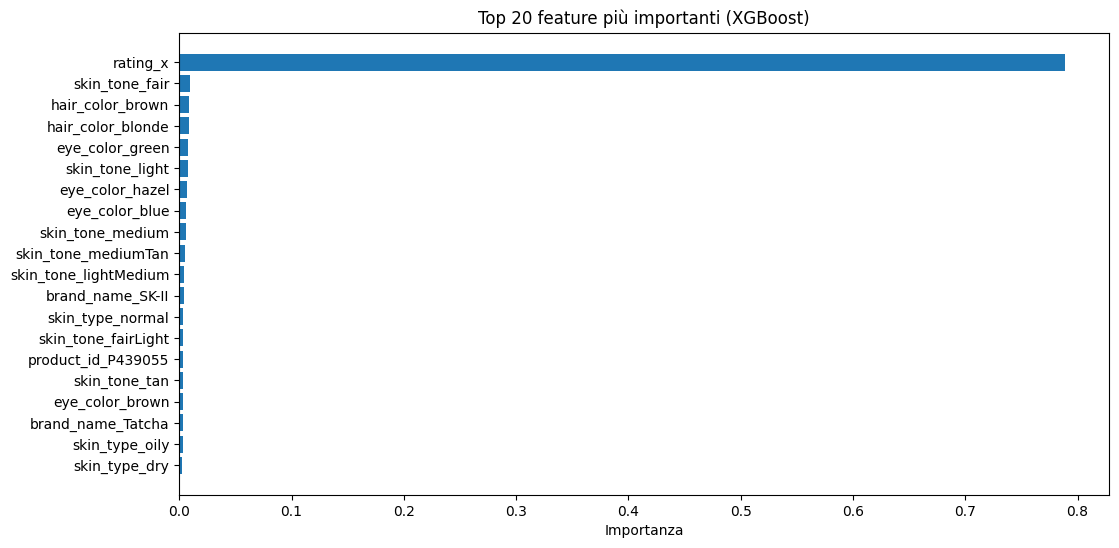

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
xgb_importance = model.feature_importances_
sorted_idx = xgb_importance.argsort()[-20:]
plt.barh(range(20), xgb_importance[sorted_idx])
plt.yticks(range(20), X_encoded.columns[sorted_idx])
plt.xlabel("Importanza")
plt.title("Top 20 feature più importanti (XGBoost)")
plt.show()


## Eseguire una ricerca degli iperparametri per migliorare le performance del modello XGBoost.
propongo una Randomized Search: è più veloce della grid search e molto efficace per modelli complessi come gli alberi di decisione.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split

#TROPPO LENTO, FARE QUALCOSA, PARTIRE DA QUI

# Spazio degli iperparametri da esplorare
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(3, 7),
    'learning_rate': uniform(0.05, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

xgb = XGBRegressor(random_state=42)

# Ricerca random con cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,  # numero di combinazioni da testare
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Avvia la ricerca su un sottoinsieme del training set per effettuare la ricerca parametrica più velocemente
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)
random_search.fit(X_sample, y_sample)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a7028849050>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a7028778190>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a7028778710>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a702888a0d0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

## Migliori parametri e valutazione finale

In [ ]:
print("Migliori parametri trovati:")
print(random_search.best_params_)

# Miglior modello trovato
best_model = random_search.best_estimator_

# Valutazione su test set
y_best_pred = best_model.predict(X_test)
rmse_best = mean_squared_error(y_test, y_best_pred)
r2_best = r2_score(y_test, y_best_pred)

print(f"RMSE ottimizzato: {rmse_best:.4f}")
print(f"R2 ottimizzato: {r2_best:.4f}")


Migliori parametri trovati:
{'colsample_bytree': np.float64(0.5909124836035503), 'gamma': np.float64(0.9170225492671691), 'learning_rate': np.float64(0.11084844859190755), 'max_depth': 4, 'n_estimators': 138, 'reg_alpha': np.float64(0.2912291401980419), 'reg_lambda': np.float64(0.6118528947223795), 'subsample': np.float64(0.569746930326021)}
RMSE ottimizzato: 0.0251
R2 ottimizzato: 0.8997


# Conclusioni e sviluppi futuri
In questo progetto sono stati implementati e confrontati vari modelli di sistemi di raccomandazione. I risultati mostrano come alcuni algoritmi, come SVD, abbiano tempi ridotti di training e performance discrete, confronto a gli alberi di regressione che hanno tempi di training e ottimizzazione più lunghi, ma più precisi nella recommendation.

### Limiti
- Il dataset utilizzato per l'ottimizzazione è relativamente piccolo rispetto a quelli utilizzati in contesti industriali.
- L'analisi è focalizzata solo su modelli singoli, senza considerare approcci ibridi.